In [1]:
import sys 
import os
sys.path.append(os.path.abspath(os.path.join('..')))

import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt
from data import PVDataGenerator, PV_LFM_Dataset
from data.utils import *
from alfi.utilities.data import flatten_dataset
from models import ExactLFM
from pv_plot import plot_train_test_split

In [67]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 60
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 3
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 4
N_SYSTEMS = 15
RADIUS = 0.35
COORDS = (55, -1.5)
NUM_OUTPUTS = 4


==> Loading data
==> Loaded data in: 0 m : 5 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



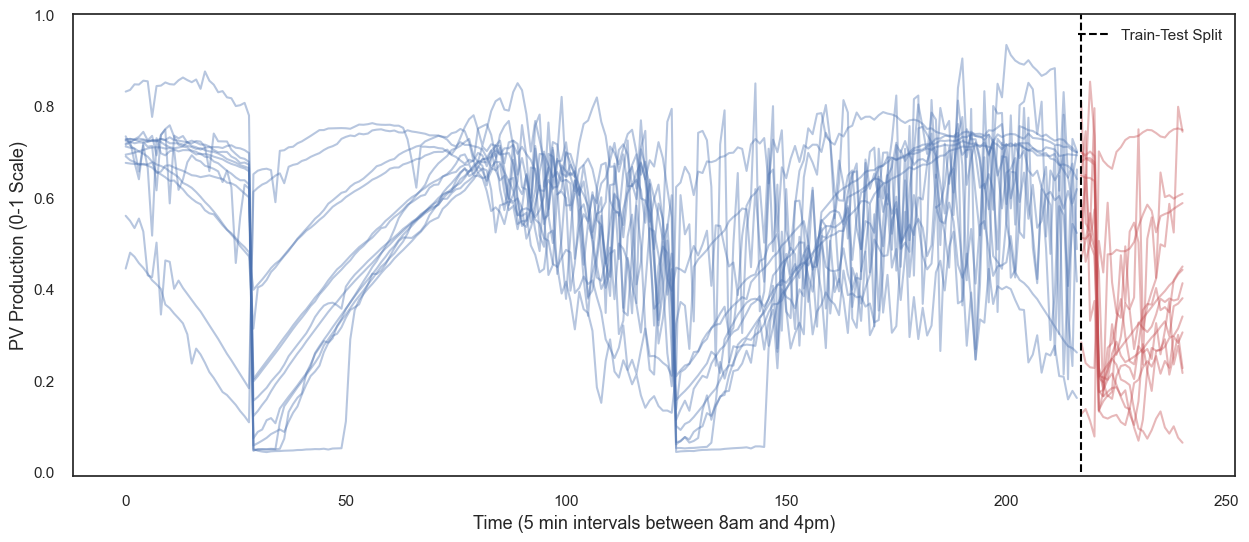

In [68]:
generator = PVDataGenerator(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')
# set text font to Arial
plt.rcParams['font.family'] = "Arial"

X, y = generator.get_time_series()
x_train, y_train, x_test, y_test = train_test_split(X, y, hour=12)
plot_train_test_split(y_train, y_test)


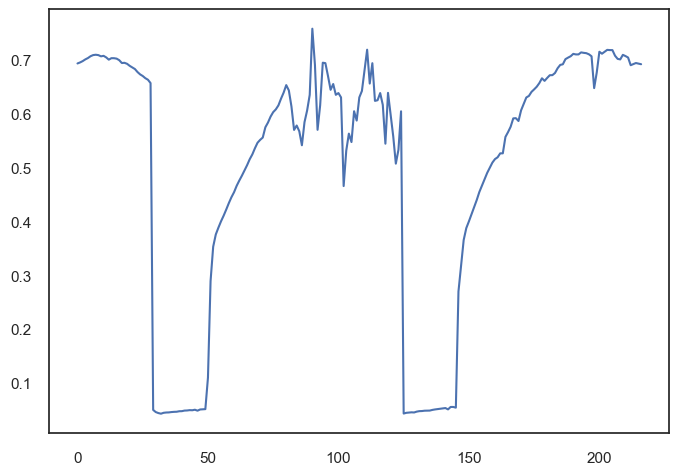

In [69]:
interval = 1

x_obs = x_train[::interval] 
# add noise to observations
y_obs = y_train[::interval, 0] 

plt.plot(y_obs)

# Exact Latent Force Model

In [70]:
N_OBS = 1
m_observed = y_obs.unsqueeze(-1)
f_observed = x_obs.unsqueeze(-1)

t_obs = torch.linspace(0, 1, len(x_obs))
t_train = torch.linspace(0+1/1e2, 1 - 1/1e2 , len(x_train)) 
t_test = torch.linspace(1, (len(x_test) + len(x_train))/len(x_train), len(x_test))

# t_obs = x_obs
# t_train = x_train
# t_test = x_test

In [71]:
# create dataset
dataset = PV_LFM_Dataset(N_OBS, m_observed, f_observed, t_obs, 0.1*torch.ones(N_OBS) )
train_t, train_y = flatten_dataset(dataset)

train_t = train_t.view(-1, 1)
train_y = train_y.view(-1, 1)

In [72]:
model = ExactLFM(dataset, dataset.variance.reshape(-1))                                                      
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_fn = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model) 

In [73]:
from trainers import ExactTrainer

track_parameters = [
    'mean_module.raw_basal',
    'covar_module.raw_decay',
    'covar_module.raw_sensitivity',
    'covar_module.raw_lengthscale',
]
trainer = ExactTrainer(model, [optimizer], dataset, loss_fn=loss_fn, track_parameters=track_parameters)
# trainer = ConstrainedTrainer(model, [optimizer], dataset, loss_fn=loss_fn, track_parameters=track_parameters)

model.likelihood.train()
a = trainer.train(epochs=200, report_interval=50)


Epoch 001/200 - Loss: 0.78 λ: [0.08]
Epoch 051/200 - Loss: -0.76 λ: [0.08]
Epoch 101/200 - Loss: -1.03 λ: [0.08]
Epoch 151/200 - Loss: -1.04 λ: [0.08]


In [82]:
t_predict_train = torch.linspace(t_train.min(), t_train.max(), len(t_train)*2 )
t_predict_test = torch.linspace(t_test.min(), t_test.max(), len(t_test))
jitter = 1e-3
p_m_train = model.predict_m(t_predict_train, jitter=jitter)
p_m_test = model.predict_m(t_predict_test, jitter=jitter)


Text(0, 0.5, 'PV Output (0-1 Scale)')

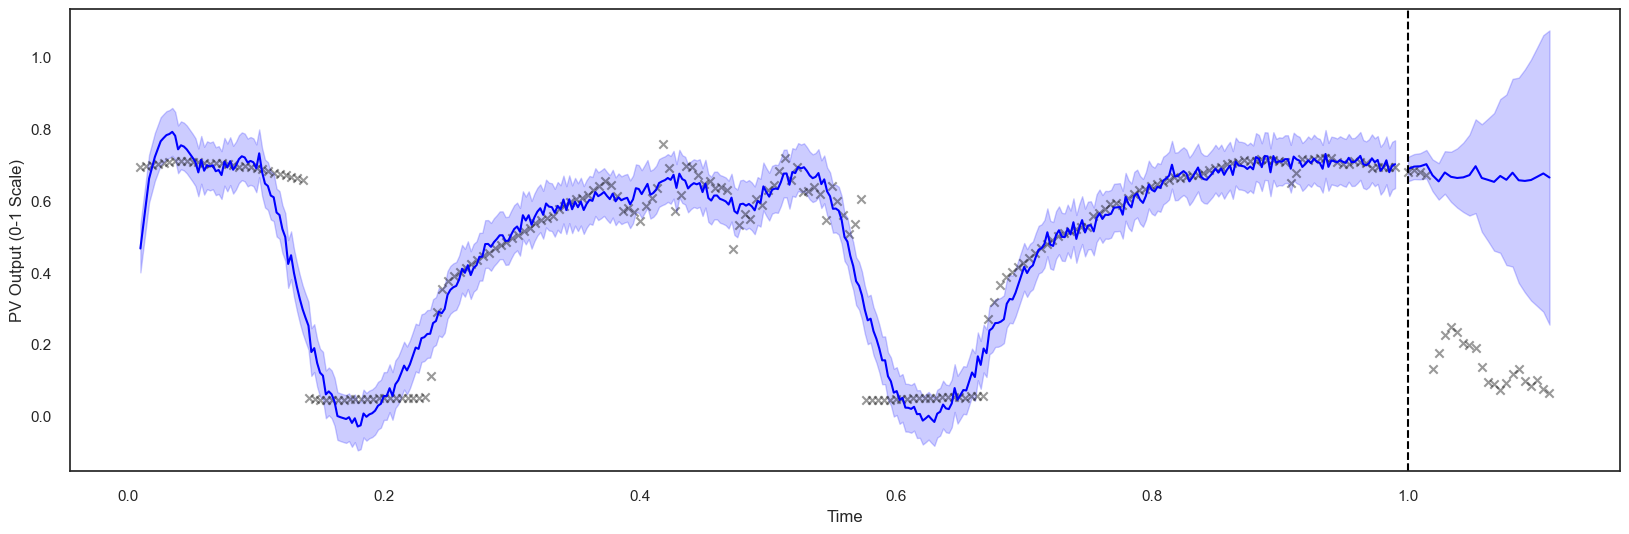

In [83]:
pv_mean_train = p_m_train.mean.detach().numpy().transpose(0, 1)
pv_std_train = p_m_train.variance.detach().sqrt().numpy().transpose(0, 1)

pv_mean_test = p_m_test.mean.detach().numpy().transpose(0, 1)
pv_std_test = p_m_test.variance.detach().sqrt().numpy().transpose(0, 1)

fig, axs = plt.subplots(1, 1, figsize=(20, 6))

pv_mean_train = pv_mean_train.squeeze()
pv_std_train = pv_std_train.squeeze()
pv_mean_test = pv_mean_test.squeeze()
pv_std_test = pv_std_test.squeeze()

axs.plot(t_predict_train, pv_mean_train, color='blue', label='Mean')
axs.fill_between(t_predict_train, pv_mean_train - 2*pv_std_train, 
                    pv_mean_train + 2*pv_std_train, color='blue', alpha=0.2, label='95% CI')
axs.plot(t_predict_test, pv_mean_test, color='blue')
axs.fill_between(t_predict_test, pv_mean_test - pv_std_test, pv_mean_test + pv_std_test, color='blue', alpha=0.2)
axs.scatter(t_train, y_train[:,0], color='black', alpha=0.4, marker='x')
axs.scatter(t_test, y_test[:,0], color='black', alpha=0.4, marker='x')
axs.axvline(x=t_obs.max(), color='black', linestyle='--', label='Train-Test Split')

axs.set_xlabel('Time')
axs.set_ylabel('PV Output (0-1 Scale)')
